In [80]:
import pandas as pd
from lxml import html
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.ensemble import RandomForestClassifier
import gensim
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter,defaultdict
from string import punctuation
import os
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from lxml import etree
from xml.dom import minidom
import xml.etree.cElementTree as et
 

In [81]:
morph = MorphAnalyzer()
punct = punctuation+'«»—…“”*№–'
stops = set(stopwords.words('russian'))

def normalize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]
    words = [morph.parse(word)[0].normal_form for word in words if word and word not in stops]

    return ' '.join(words)

def tokenize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]

    return ' '.join(words)

### Готовим данные

In [82]:
data_train = pd.read_csv('news_texts.csv')

In [83]:
data_train.dropna(inplace=True)

In [84]:
data_train['content_norm'] = data_train['content'].apply(normalize)

In [85]:
corpus_xml = html.fromstring(open('paraphrases.xml', 'rb').read())
texts_1 = []
texts_2 = []
classes = []

for p in corpus_xml.xpath('//paraphrase'):
    texts_1.append(p.xpath('./value[@name="text_1"]/text()')[0])
    texts_2.append(p.xpath('./value[@name="text_2"]/text()')[0])
    classes.append(p.xpath('./value[@name="class"]/text()')[0])
    
data = pd.DataFrame({'text_1':texts_1, 'text_2':texts_2, 'label':classes})

In [86]:
data['text_1_norm'] = data['text_1'].apply(normalize)
data['text_2_norm'] = data['text_2'].apply(normalize)

In [87]:
data.head()

,text_1,text_2,label,text_1_norm,text_2_norm
0,Полицейским разрешат стрелять на поражение по ...,Полиции могут разрешить стрелять по хулиганам ...,0,полицейский разрешить стрелять поражение гражд...,полиция мочь разрешить стрелять хулиган травма...
1,Право полицейских на проникновение в жилище ре...,Правила внесудебного проникновения полицейских...,0,право полицейский проникновение жилища решить ...,правило внесудебный проникновение полицейский ...
2,Президент Египта ввел чрезвычайное положение в...,Власти Египта угрожают ввести в стране чрезвыч...,0,президент египет ввести чрезвычайный положение...,власть египет угрожать ввести страна чрезвычай...
3,Вернувшихся из Сирии россиян волнует вопрос тр...,Самолеты МЧС вывезут россиян из разрушенной Си...,-1,вернуться сирия россиянин волновать вопрос тру...,самолёт мчс вывезти россиянин разрушить сирия
4,В Москву из Сирии вернулись 2 самолета МЧС с р...,Самолеты МЧС вывезут россиян из разрушенной Си...,0,москва сирия вернуться 2 самолёт мчс россиянин...,самолёт мчс вывезти россиянин разрушить сирия


Распарсили тестовые данные, открыли обучающие.

### SVD и NMF: матричные разложения
Обучаем на тестовых данных

In [89]:
cv = CountVectorizer(min_df=3, max_df=0.4, max_features=1000)
X = cv.fit_transform(data_train['content_norm'])

In [90]:
X.shape

(7212, 1000)

In [91]:
svd = TruncatedSVD(200)
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=200, n_iter=5,
       random_state=None, tol=0.0)

In [ ]:
#tsne = TSNE(2).fit_transform(svd.components_.T)#

In [92]:
id2word = {i:w for i,w in enumerate(cv.get_feature_names())}
word2id = {w:i for i,w in id2word.items()}

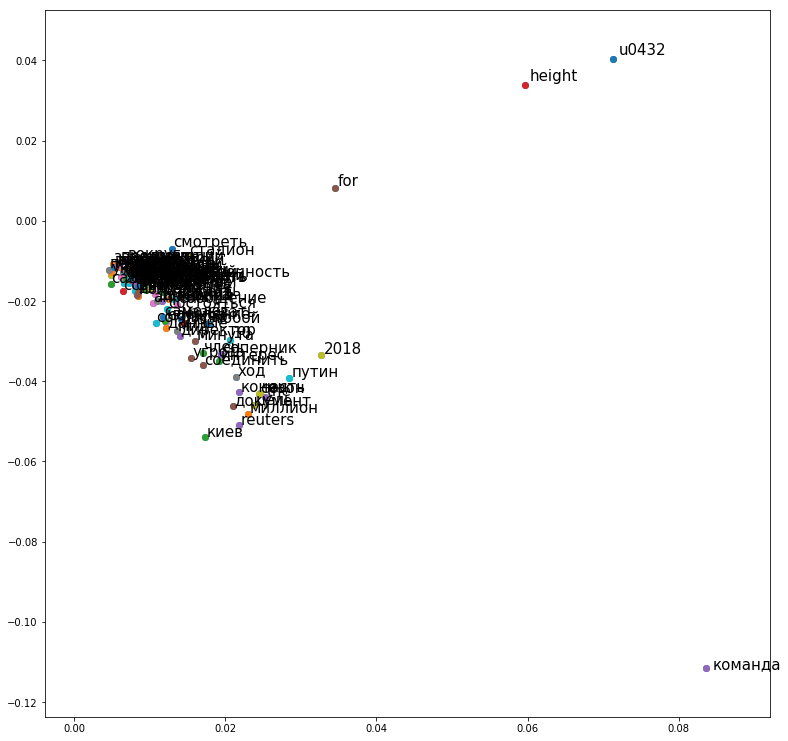

In [93]:
random_inds = np.random.choice(range(len(id2word)), 100, replace=False)
res = svd.components_.T[random_inds]
# res = tsne[random_inds]

plt.figure(figsize=(13,13))
plt.scatter(res[:,0], res[:,1])
for i, coor in enumerate(random_inds):
    x, y = res[i, 0], res[i, 1]
    plt.scatter(x, y)
    
    plt.annotate(id2word[coor], xy=(x, y), xytext=(x*1.01, y*1.01), textcoords='data',
                   ha='left', va='bottom', fontsize=15)

In [94]:
nmf = NMF(50)
nmf.fit(X)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=50, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [95]:
svd = TruncatedSVD(50)
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0)

In [96]:
id2word = {i:w for i,w in enumerate(cv.get_feature_names())}
word2id = {w:i for i,w in id2word.items()}

In [97]:
id2vec_svd = nmf.components_.T
id2vec_nmf = svd.components_.T

In [98]:
def most_similar(word, id2vec):
    similar = [id2word[i] for i in cosine_distances(id2vec[word2id[word]].reshape(1, -1), id2vec).argsort()[0][:10]]
    return similar

In [99]:
most_similar('спорт', id2vec_svd)

['спорт',
 'олимпийский',
 'спортивный',
 'спортсмен',
 'олимпиада',
 'мокнуть',
 'флаг',
 'пхёнчхан',
 'сочи',
 'допинг']

In [100]:
most_similar('спорт', id2vec_nmf)

['спорт',
 'спортсмен',
 'спортивный',
 'допинг',
 'мокнуть',
 'флаг',
 'олимпийский',
 'федерация',
 'участвовать',
 'соревнование']

Кластеризация

In [101]:
cluster = MiniBatchKMeans(500, n_init=2, verbose=1, max_no_improvement=100, reassignment_ratio=0.4)
cluster.fit(nmf.components_.T)

Init 1/2 with method: k-means++


C:\Users\ksenia\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


Inertia for init 1/2: 57.609195
Init 2/2 with method: k-means++
Inertia for init 2/2: 78.700443
Minibatch iteration 1/1000: mean batch inertia: 1.097878, ewa inertia: 1.097878 
Minibatch iteration 2/1000: mean batch inertia: 1.330537, ewa inertia: 1.144364 
Minibatch iteration 3/1000: mean batch inertia: 1.039925, ewa inertia: 1.123497 
Minibatch iteration 4/1000: mean batch inertia: 3.589424, ewa inertia: 1.616189 
Minibatch iteration 5/1000: mean batch inertia: 1.185849, ewa inertia: 1.530207 
Minibatch iteration 6/1000: mean batch inertia: 0.878045, ewa inertia: 1.399905 
Minibatch iteration 7/1000: mean batch inertia: 3.872271, ewa inertia: 1.893884 
Minibatch iteration 8/1000: mean batch inertia: 3.368069, ewa inertia: 2.188427 
Minibatch iteration 9/1000: mean batch inertia: 1.514360, ewa inertia: 2.053748 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 10/1000: mean batch inertia: 2.569057, ewa inertia: 2.156707 
Minibatch iteration 11/1000: mean batch ine

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=100,
        n_clusters=500, n_init=2, random_state=None,
        reassignment_ratio=0.4, tol=0.0, verbose=1)

In [102]:
cls = defaultdict(list)

for i, cl in enumerate(cluster.labels_):
    cls[cl].append(id2word[i])

f = open('cluster_nmf.txt', 'w')
for cl in cls:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls[cl]))
    f.write('\n\n')
f.close()

### Обучаем Word2Vec и Fasttext

In [104]:
fast_text = gensim.models.FastText([text.split() for text in data_train['content_norm']], size=50, min_n=4, max_n=8)
w2v = gensim.models.Word2Vec([text.split() for text in data_train['content_norm']], size=50, sg=1)

C:\Users\ksenia\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


ValueError: too many values to unpack (expected 2)

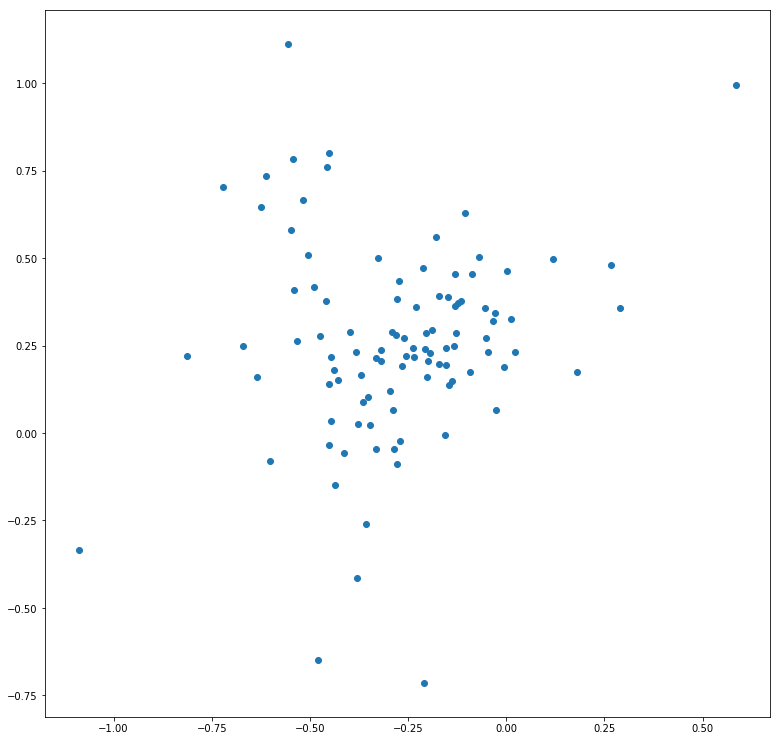

In [105]:
random_words = np.random.choice(w2v.wv.index2word, 100, replace=False)
res = w2v[random_words]
# res = TSNE(2).fit_transform(res)

plt.figure(figsize=(13,13))
plt.scatter(res[:,0], res[:,1])
for i, coor in enumerate(res):
    x, y = coor
    plt.scatter(x, y)
    
    plt.annotate(random_words[i], xy=(x, y), xytext=(x*1.01, y*1.01), textcoords='data',
                   ha='left', va='bottom', fontsize=15)

In [107]:
fast_text = gensim.models.FastText([text.split() for text in data_train['content_norm']], size=50, min_n=4, max_n=8)
w2v = gensim.models.Word2Vec([text.split() for text in data_train['content_norm']], size=50, sg=1)

In [108]:
fast_text.most_similar('путин')

C:\Users\ksenia\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
C:\Users\ksenia\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('путинцев', 0.9855004549026489),
 ('ватутин', 0.9539036750793457),
 ('распутин', 0.9289225339889526),
 ('федутин', 0.901850700378418),
 ('путч', 0.7424615621566772),
 ('песок', 0.670208215713501),
 ('песо', 0.6589630246162415),
 ('гройсман', 0.6528561115264893),
 ('соломатин', 0.6408776044845581),
 ('дутерот', 0.6375821828842163)]

In [109]:
w2v.most_similar('путин')

C:\Users\ksenia\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
C:\Users\ksenia\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('владимир', 0.8385375738143921),
 ('послание', 0.8073840141296387),
 ('колокольцев', 0.7921226024627686),
 ('эрдоган', 0.7853175401687622),
 ('kremlin.ru', 0.7721611261367798),
 ('в.в', 0.7714988589286804),
 ('рухани', 0.7661030888557434),
 ('роухани', 0.7643266916275024),
 ('президент', 0.7634550333023071),
 ('кремль', 0.7546113729476929)]

In [113]:
corpus = [text.split() for text in data_train['content'].apply(tokenize)]
fast_text = gensim.models.FastText(corpus, size=50, min_n=4, max_n=8)

### Решение дз: преобразование текстов разными методами

In [115]:
tfidf=TfidfVectorizer()

In [116]:
X_train,X_test,y_train,y_test=train_test_split(data.iloc[:,1:],data["label"],train_size=7224)

C:\Users\ksenia\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [117]:
X_train.shape[0]

7224

In [118]:

tfidf.fit([X_train.loc[i,"text_1_norm"]+" "+X_train.loc[i,"text_2_norm"] for i in list(X_train.index)])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

### SVD

In [119]:
svd=TruncatedSVD(30)

In [120]:
svd.fit(tfidf.transform([X_train.loc[i,"text_1_norm"]+" "+X_train.loc[i,"text_2_norm"] for i in list(X_train.index)]))

TruncatedSVD(algorithm='randomized', n_components=30, n_iter=5,
       random_state=None, tol=0.0)

In [121]:
svd_train1=svd.transform(tfidf.transform([X_train.loc[i,"text_1_norm"] for i in list(X_train.index)]))
svd_train2=svd.transform(tfidf.transform([X_train.loc[i,"text_2_norm"] for i in list(X_train.index)]))

In [122]:
svd_test1=svd.transform(tfidf.transform([X_test.loc[i,"text_1_norm"] for i in list(X_test.index)]))
svd_test2=svd.transform(tfidf.transform([X_test.loc[i,"text_2_norm"] for i in list(X_test.index)]))

In [123]:
def get_column(matrix1,matrix2):
    cosines=[]
    for i in range(len(matrix1)):
        scalar=np.dot(matrix1[i,:],matrix2[i,:])
        cosine=scalar/(np.linalg.norm(matrix1[i,:])*np.linalg.norm(matrix2[i,:]))
        cosines.append(cosine)
    return np.reshape(cosines,(len(cosines),1))

In [124]:
column1_train=get_column(svd_train1,svd_train2)
column1_test=get_column(svd_test1,svd_test2)

### NMF

In [125]:
nmf=NMF(30)
nmf.fit(tfidf.transform([X_train.loc[i,"text_1_norm"]+" "+X_train.loc[i,"text_2_norm"] for i in list(X_train.index)]))

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=30, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [126]:
nmf_train1=nmf.transform(tfidf.transform([X_train.loc[i,"text_1_norm"] for i in list(X_train.index)]))
nmf_train2=nmf.transform(tfidf.transform([X_train.loc[i,"text_2_norm"] for i in list(X_train.index)]))

In [127]:
nmf_test1=nmf.transform(tfidf.transform([X_test.loc[i,"text_1_norm"] for i in list(X_test.index)]))
nmf_test2=nmf.transform(tfidf.transform([X_test.loc[i,"text_2_norm"] for i in list(X_test.index)]))

In [128]:
column2_train=get_column(nmf_train1,nmf_train2)
column2_test=get_column(nmf_test1,nmf_test2)

### Word2vec + FastText

In [129]:
fast_text = gensim.models.FastText([text.split() for text in data['text_1_norm']], size=50, min_n=4, max_n=8)
w2v = gensim.models.Word2Vec([text.split() for text in data['text_1_norm']], size=50, sg=1)

In [130]:
def get_embeddings(text,model):
    text=text.split()
    num=Counter(text)
    
    embeddings=[]
    dictionary=set(text)
    for word in dictionary:
        try:
            embedding=model[word]*num[word]/len(text)
        except:
            embedding=np.zeros(50)
        embeddings.append(embedding)
      
    embeddings=np.array(embeddings)
    return np.average(embeddings,axis=0)

In [131]:
w2v_train1=np.array([get_embeddings(text,w2v) for text in X_train["text_1_norm"]])
w2v_train2=np.array([get_embeddings(text,w2v) for text in X_train["text_2_norm"]])

w2v_test1=np.array([get_embeddings(text,w2v) for text in X_test["text_1_norm"]])
w2v_test2=np.array([get_embeddings(text,w2v) for text in X_test["text_2_norm"]])

C:\Users\ksenia\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [132]:
fast_text_train1=np.array([get_embeddings(text,fast_text) for text in X_train["text_1_norm"]])
fast_text_train2=np.array([get_embeddings(text,fast_text) for text in X_train["text_2_norm"]])

fast_text_test1=np.array([get_embeddings(text,fast_text) for text in X_test["text_1_norm"]])
fast_text_test2=np.array([get_embeddings(text,fast_text) for text in X_test["text_2_norm"]])

C:\Users\ksenia\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [133]:
column3_train=get_column(w2v_train1,w2v_train2)
column3_test=get_column(w2v_test1,w2v_test2)

C:\Users\ksenia\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [134]:
column4_train=get_column(fast_text_train1,fast_text_train2)
column4_test=get_column(fast_text_test1,fast_text_test2)

### Adagram

Вот тут, к сожалению, возникла проблема с установкой адаграма под Windows. Так что финальная часть — без него :(.

### Оценка модели (без адаграма)

In [152]:
from sklearn.model_selection import cross_val_score

In [146]:
X_train=np.concatenate((column1_train,column2_train,column3_train,column4_train),axis=1)

In [147]:
X_train.shape

(7224, 4)

In [148]:
X_test=np.concatenate((column1_test,column2_test,column3_test,column4_test),axis=1)

In [149]:
clf=RandomForestClassifier(n_estimators=20)

In [150]:
X_train=np.nan_to_num(X_train)

In [153]:
print(np.mean(cross_val_score(clf,X_train,y_train,scoring="f1_micro")))

0.4923855105379227


Результат получился не очень хорошим, прямо скажем, средненьким. Мы можем попробовать улучшить его за счет оптимизации классификатора. Рассмотрим несколько вариантов.

### Оптимизация модели

In [154]:
clf1=RandomForestClassifier(n_estimators=10)

In [155]:
clf2=RandomForestClassifier(n_estimators=10,max_depth=5)

In [156]:
clf3=RandomForestClassifier(n_estimators=30,max_depth=5)

In [157]:
clf4=RandomForestClassifier(n_estimators=40,max_depth=10)

In [158]:
print(np.mean(cross_val_score(clf1,X_train,y_train,scoring="f1_micro")))

0.47937740886296876


In [159]:
print(np.mean(cross_val_score(clf2,X_train,y_train,scoring="f1_micro")))

0.5160609214504431


In [160]:
print(np.mean(cross_val_score(clf3,X_train,y_train,scoring="f1_micro")))

0.5189664614380152


In [161]:
print(np.mean(cross_val_score(clf4,X_train,y_train,scoring="f1_micro")))

0.5195190795041725


In [162]:
clf5=RandomForestClassifier(n_estimators=50,max_depth=15)

In [163]:
print(np.mean(cross_val_score(clf5,X_train,y_train,scoring="f1_micro")))

0.5081680829127283


Наиболее высокий результат показала четвертая модель, хотя различаются они все незначительно. Заметно, что при уменьшении n_estimators качество падает.
